In [2]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-tgvpqxti
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-tgvpqxti
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=375457 sha256=bfa64857222dd05c4610cbdcc2b2befa003a1e33b8a2ecf4ec4cbf2af0818f40
  Stored in directory: /tmp/pip-ephem-wheel-cache-gya3_b3k/wheels/39/61/b4/480fbddb4d3d6bc34083e7397bc6f5d1381f79acc68e9f3511
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.7
    Uninstalling pycocotools-2.0.7:
      Successfully uninstalled pycocotools-2.0.7


In [3]:
%%shell
git clone https://github.com/MbassiJaphet/pytorch-for-information-extraction.git


Cloning into 'pytorch-for-information-extraction'...
remote: Enumerating objects: 1170, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 1170 (delta 6), reused 5 (delta 5), pack-reused 1150
Receiving objects: 100% (1170/1170), 39.14 MiB | 29.21 MiB/s, done.
Resolving deltas: 100% (556/556), done.


In [4]:
%cd pytorch-for-information-extraction/code

/content/pytorch-for-information-extraction/code


## **Introduction**
Welcome to this tutorial entitled **' Pytorch For Information Extraction'**. As the title implies, this tutorial demonstrates how possible it is to automate information retrieval on document images using **Machine Learning** with **Pytorch**. This tutorial primarily focuses on ways to leverage Pytorch and its features to address the complex task of Information Extraction on structured document images. In order to better understand this tutorial it is all about, it is important to clarify definitions and meanings concerning a few things.

Firstly, what is **Information Extraction**? According to Wikipedia, "Information Extraction is the task of automatically extracting structured information from unstructured and/or semi-structured machine-readable documents and other electronically represented sources".

Secondly, what are **structured document images**? This tutorial defines a structured document image as a digital image of a document like IDs, bills,  cheques, passport, driving license, etc on which every information (such as name, age, sex, expiry date, etc)  inscribed has a predefined position or field on the document.

Therefore,  this tutorial is a walkthrough leveraging Pytorch with the most convenient features to perform information extraction on documents images. In other words, at the end of the tutorial, we shall build a system that takes an image of a structured document (like a student id card) and extracts inscribed information (such as student’s name,  department, date of birth, etc) as outputs.


## **Target Audience**
* AI practitioners and enthusiasts with interest in either Computer Vision, Machine Learning, or Pytorch.
* Developers exploring ways to leverage machine learning to develop information extraction systems.
* Researchers and academicians exploring various paths and possibilities for developing information extraction systems.
* Developers willing to learn key or primordial features of Pytorch looking forward to implementing the later in developing solutions aimed at solving real-world problems.
* Finally anyone interested and willing to learn Pytorch. Particularly for building computer vision systems like the one this tutorial is built on top of.
\
This tutorial assumes the reader's familliarity with Python and may be small machine learning background. Prior knowledge of Pytorch is not an absolute prerequisite, though having some basic knowledge of Pytorch will help the reader to rapidly catch-on the Pytorch related content and walk through faster. So, for our Pytorch beginners' audience, there is no need to worry about not being able to follow the tutorial since the project being use as foundation for the Pytorch educative materials is developed from scratch.

## **Project Description**

This tutorial is based on a project which aims at developing a pipeline that will take as input an image containing student-id(s) from the Student-ID testing dataset and extract information of interest from student-id in that image.

### Project Difficulties
The main difficulties of the project are well-known difficulties from the long history of Information Extraction by Computer Vision systems. Thankfully, due to innovations brought by deep learning most of those difficulties can now be overcomed and considered as part of a distant past.
* Identification of documents (student-ids) in images.
* Complex backgrounds making the detection of documents difficult.
* Documents that might not be in the right orientation.
* Mechanisms for extracting desired information in the correct form.


### Project Modules/Layout
As an attempt to go through the difficulties mentioned above, the project itself is subdivided into three modules within which Pytorch and Machine Learning play important roles:

1.   A **Detection Module,** responsible for detecting the presence of one or more documents in an image. After detecting documents in images, this module is required to provide information on the position of documents on the image.
2.   An **Orientation Module,** next to the detection module watches the orientation of documents and rectifies it when necessary by applying the proper transformation on images.
3.   An **Information Extraction Module,** last in the chain extracts information of fields from documents of interest contained in images.

This tutorial is more like a mini course on leveraging Pytorch and its features for Information Extraction, than being a simple straight forward tutorial. So, feel free to pause and take a break anytime at the end of each section/module, as even the structure of the notebook allows you to resume your work from where you left.



# **1. Detection Module**
To detect and locate the position of documents in images, we gonna use fine-tuning on the state of art object segmentation algorithm **Mask R-CNN**  on top of pre-trained **ResNet-50** available in torchvision models repository.


So, let's resolve the imports of our detection module.

In [4]:
# Resolve imports for detection module
import os
import cv2
import time
import torch
import torchvision

import numpy as np

import utils

from PIL import Image, ImageDraw, ImageFilter
#%matplotlib inline
from matplotlib import pyplot as plt

# define transforms to convert PIL image to torch.Tensor
imgToTensor = torchvision.transforms.ToTensor()
# define transforms to convert torch.Tensor to PIL image
tensorToPIL = torchvision.transforms.ToPILImage()

## 1.1. Detection Dataset


### 1.1.1. Define dataset class
We shall train our detection model on the **Student-ID** dataset. So let’s examine its format !

A crucial requirement when fine-tuning, training, or inferencing models in Pytorch is to know the exact formats of data that specific models expect as inputs and compute as outputs.

Now, knowing the formats of the Student-ID dataset as well as formats of inputs and outputs of Mask R-CNN, we can confidently code a custom dataset class inheriting from torch.utils.data.Dataset.


In [5]:
class DetectionDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, mode=None, transforms=None):
        self.mode = mode
        self.data_path = data_path
        self.transforms = transforms
        # everything but our dataset classes ibelong to class 'BACKGROUND'
        self.classes = ['BACKGROUND']
        # loading our dataset classes names
        _classes_names = utils.load_json(os.path.join(data_path, 'classes.json'))['classes']
        # implicitly attributing index '0' to BACKGROUND class
        self.classes.extend(_classes_names)
        # load all image files
        dataset_file = os.path.join(data_path, str(mode).lower().__add__('.json'))
        if not os.path.exists(dataset_file):
            raise Exception("Invalid Mode: '{}'\n Available modes are: 'TRAIN', 'VALID', 'TEST'.".format(mode))
        data_dict = utils.load_json(dataset_file)
        self.image_urls = dict()
        self.annotation_urls = dict()
        for object_id, item_dict in enumerate(data_dict['data']):
            self.image_urls[object_id] = item_dict['image_url'].replace('\\', '/')
            self.annotation_urls[object_id] = item_dict['annotation_url'].replace('\\', '/')

    def __getitem__(self, idx):
        # load images and annotations
        image_url = self.image_urls[idx]
        annotation_url = self.annotation_urls[idx]
        annotation_dict = utils.load_json(annotation_url)
        image = Image.open(image_url)
        image_height, image_width = image.size
        num_objects = len(annotation_dict['shapes'])
        labels, boxes, polygons = list(), list(), list()
        target = dict()

        for idx, shape in enumerate(annotation_dict['shapes']):
            label = self.classes.index(shape['label'].upper())
            polygon = [(int(x), int(y)) for x, y in shape['points']]
            labels.append(label)
            polygons.append(polygon)

        masks_array = np.zeros((image_width, image_height))
        masks_array = utils.draw_polygons_on_image_array(masks_array, polygons)
        object_ids = np.unique(masks_array)[1:]  # Remove index for background
        mask_arrays = masks_array == object_ids[:, None, None]

        for mask_array in mask_arrays:
            box = utils.compute_box_from_mask_array(mask_array)
            boxes.append(box)

        labels_tensor = torch.from_numpy(np.array(labels))
        boxes_tensor = torch.as_tensor(boxes, dtype=torch.float32)
        masks_tensor = torch.as_tensor(mask_arrays, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes_tensor[:, 3] - boxes_tensor[:, 1]) * (boxes_tensor[:, 2] - boxes_tensor[:, 0])

        is_crowd = torch.zeros((num_objects,), dtype=torch.int64)

        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = is_crowd
        target["labels"] = labels_tensor
        target["boxes"] = boxes_tensor
        target["masks"] = masks_tensor

        if self.transforms is not None: image_tensor, target = self.transforms(image, target)

        return image_tensor, target

    def __len__(self):
        return len(self.image_urls)

### 1.1.2. Define transforms for detection dataset

Let's write some helper functions for data augmentation / transformation.

In [6]:
import modules.detection.scripts.transforms as detection_transforms

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(detection_transforms.ToTensor())
    ### feel free to add additional transforms here below

    return detection_transforms.Compose(transforms)

### 1.1.3. Initialize detection datasets

In [7]:
detection_data_path = os.path.join('datasets', 'detection')
# training dataset
detection_train_set = DetectionDataset(detection_data_path, mode='train', transforms=get_transform(True))
# validation dataset
detection_valid_set = DetectionDataset(detection_data_path, mode='valid', transforms=get_transform(True))
#testing dataset
detection_test_set = DetectionDataset(detection_data_path, mode='test', transforms=get_transform(False))

detection_classes = detection_train_set.classes
num_detection_classes  = len(detection_classes)

Just checking the names and number of classes from our detection dataset to make sure everything is **OK**!

In [8]:
print('Number of classes: {}\nClasses: {}'.format(num_detection_classes, detection_classes))

Number of classes: 2
Classes: ['BACKGROUND', 'STUDENT_ID']


### 1.1.4. Visualize detection dataset

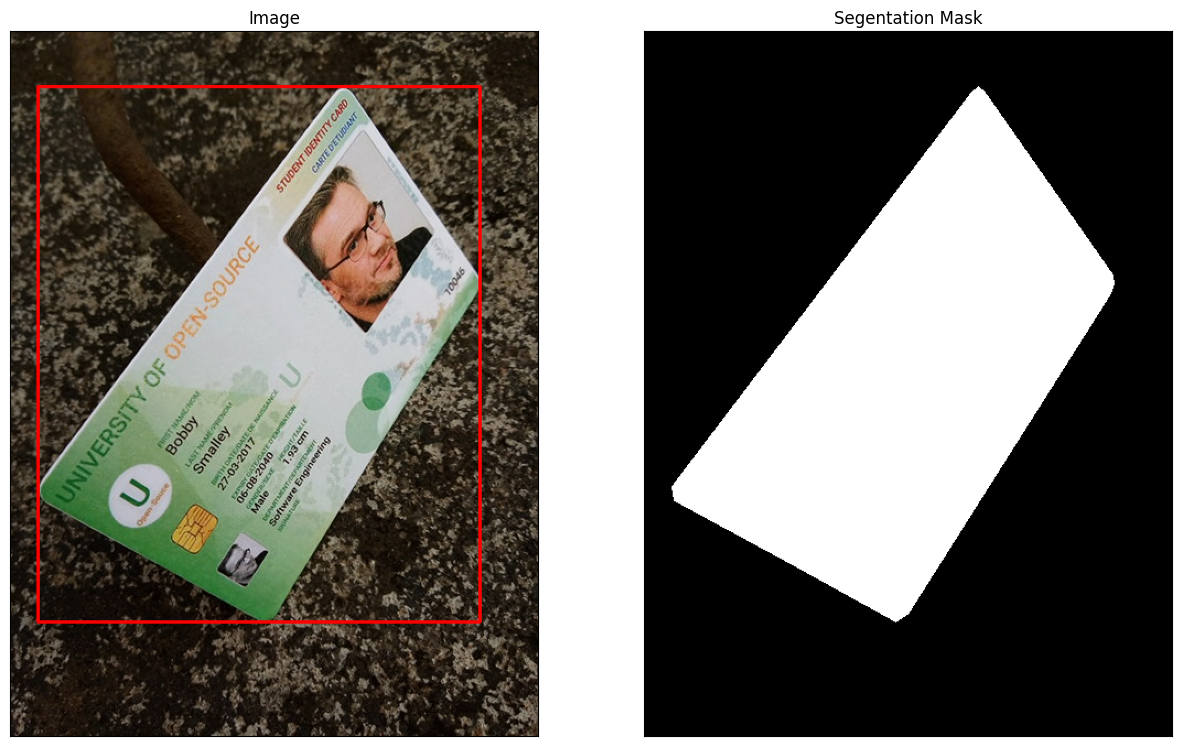

In [9]:
id = 0
obj_id = None
obj_label = ''
fig = plt.figure(figsize=(15, 15))

image_tensor, targets = detection_train_set[id]

boxes = targets['boxes'] # retrieve bounding boxes
image = utils.tensorToPIL(image_tensor)
image_array = np.array(image)

for box in boxes :
  cv2.rectangle(image_array, (int(box[0]),int(box[1])), (int(box[2]),int(box[3])), (255,0,0), 2) # draw bounding boxes

ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plt.imshow(Image.fromarray(image_array))
ax.set_title('Image')

if obj_id is not None:
    mask_tensor = targets['masks'][obj_id] # retrieve bounding masks
    obj_label_idx = targets['labels'][[obj_id]].item() # retrieve bounding labels
    obj_label = ': ' + detection_classes[obj_label_idx]
else :
    mask_tensor = torch.zeros_like(image_tensor)
    for _mask_tensor in targets['masks'] : mask_tensor += _mask_tensor # paste mask for every object

ax1 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax1.set_title('Segentation Mask' + obj_label)
mask = utils.tensorToPIL(mask_tensor)
plt.imshow(mask)
None

## 1.2. Detection Model

### 1.2.1. Define detection model
Let's define helper function to instantiate the detection model !


In [10]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_instance_segmentation_model(num_classes, state_dict=None):
    # load an instance segmentation model pre-trained on COCO
    detection_model = torchvision.models.detection.maskrcnn_resnet50_fpn(progress=True, pretrained=True)
    # get the number of input features for the classifier
    in_features = detection_model.roi_heads.box_predictor.cls_score.in_features
    ### FINETUNE pret-trained model
    # replace the pre-trained head with a new one
    detection_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    # now get the number of input features for the mask classifier
    in_features_mask = detection_model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    detection_model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer,  num_classes)
    if state_dict is not None: detection_model.load_state_dict(state_dict)
    return detection_model

**Remark:** The helper function above alows us to fine tune the pre-trained **FastRCNNPredictor** and **MaskRCNNPredictor** with desired number of classes, which are **'2'** in our case i.e. for the 'BACKGROUND' and 'Student_ID' classes.\
The function also sets the number of hidden layers for **MaskRCNNPredictor** to **'256'** but we can decide to tweak that for the best of our model performance.

### 1.2.2. Specify checkpoint and initialize model
Looking forward to **resumable** training and saving of our detection model, we shall now specify the checkpoints for the **state dictionaries** of the model and its training optimizer.

In [11]:
# select hardware use for computations
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

load_detection_checkpoint = True
save_detection_checkpoint = False

detection_checkpoint_path = os.path.join('checkpoints', 'detection_mask_rcnn_resnet50.pth.tar')

'''
Do not edit the lines below
'''

if load_detection_checkpoint :
  detection_checkpoint = torch.load(detection_checkpoint_path, map_location=device) if os.path.exists(detection_checkpoint_path) else None
  detection_model_state_dict = detection_checkpoint['model_state_dict'] if not detection_checkpoint == None else None
  detection_optimizer_state_dict = detection_checkpoint['optimizer_state_dict'] if not detection_checkpoint == None else None
else :
  detection_checkpoint, detection_model_state_dict, detection_optimizer_state_dict = None, None, None

if not save_detection_checkpoint : detection_checkpoint_path = None
# initialize detection model using the state dictionary from checkpoint
detection_model = get_instance_segmentation_model(num_detection_classes, state_dict = detection_model_state_dict)

if detection_checkpoint == None : print('No checkpoint loaded ! Loaded pre-trained model instead...')
else :
  print('Loaded model from checkpoint...')
  utils.checkpoint_summary(detection_checkpoint)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:03<00:00, 59.3MB/s]


No checkpoint loaded ! Loaded pre-trained model instead...


## 1.3. Training and Evaluation
Note that the files use for training and validation of detection module found ``./modules/detection/scripts`` folder were directly copied along with their dependencies from torchvision reference detection training scripts repository.

### 1.3.1. Specify data loaders
After initialising the various detection datasets, let us use them to specify data loaders which shall be used for training, validation and testing.

In [12]:
import modules.detection.scripts.utils as script_utils

# data loader for training
detection_train_loader = torch.utils.data.DataLoader(
    detection_train_set, batch_size=6, shuffle=True, num_workers=4,
    collate_fn=script_utils.collate_fn)

# data loader for validation
detection_valid_loader = torch.utils.data.DataLoader(
    detection_valid_set, batch_size=2, shuffle=False, num_workers=2,
    collate_fn=script_utils.collate_fn)

# data loader for testing
detection_test_loader = torch.utils.data.DataLoader(
    detection_test_set, batch_size=2, shuffle=False, num_workers=0,
    collate_fn=script_utils.collate_fn)

# defining orientation data loaders dictionary
detection_loaders = {
    'train' : detection_train_loader,
    'valid' : detection_valid_loader,
    'test' : detection_test_loader,
}

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### 1.3.2. Initialize model and optimizer
Lets initialize optimizer for training the detection model, and get ready for training !

In [13]:
# activate gradients calculation for unfreezed parameters
detection_params = [p for p in detection_model.parameters() if p.requires_grad]
# initialize training optimizer with learning rate, momentum and weight decay
detection_optimizer = torch.optim.SGD(detection_params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# define learning rate schelduler to gradually decay learning rate
detection_lr_scheduler = torch.optim.lr_scheduler.StepLR(detection_optimizer, step_size=10, gamma=0.95)

# load optimizer state dictionary from checkpoint if available
if detection_optimizer_state_dict is None:  print('No checkpoint loaded ! Optimizer not loaded from checkpoint...')
else:
    detection_optimizer.load_state_dict(detection_optimizer_state_dict)
    print('Loaded optizer from checkpoint...')

No checkpoint loaded ! Optimizer not loaded from checkpoint...


### 1.3.3. Define training function
Now, let's write the function that will train and validate our model for us. Inside the trainingg function, we shall add few lines of code that will save our model checkpoints.

In [15]:
# import training and evaluation functions
from modules.detection.scripts.engine import train_one_epoch, evaluate

def train_detection_model(model, num_epochs=10, loaders=None, checkpoint=None, checkpoint_path=None,
                optimizer= None, lr_scheduler= None, print_freq=1, device=torch.device('cuda')):

    if checkpoint is None: start_epoch = 1
    else:
        print('Resuming training from checkpoint...')
        start_epoch = checkpoint['epoch'] + 1

    model.to(device) # Move model to cpu or cuda device

    time_train = time.time()
    for epoch in range(start_epoch, num_epochs + 1):
        time_epoch = time.time()
        # train for one epoch, printing every '{print_freq}' iterations
        train_one_epoch(model, optimizer, loaders['train'], device, epoch, print_freq=print_freq)
        # update the learning rate
        lr_scheduler.step()
        # evaluate model on the validation dataset
        # evaluate(model, loaders['valid'], device=device)

        time_epoch_elapsed = time.time() - time_epoch
        time_train_elapsed = time.time() - time_train
        print('Epoch: {}\tEpoch Time: {:.0f}m {:.0f}s\tElapsed Time: {:.0f}m {:.0f}s'.format(
             epoch, time_epoch_elapsed // 60, time_epoch_elapsed % 60,
             time_train_elapsed // 60, time_train_elapsed % 60))

        # Save checkpoint after every epoch if checkpoint_path is given
        if not checkpoint_path == None:
            utils.save_checkpoint(model.state_dict(), optimizer.state_dict(), epoch, checkpoint_path)

    return model # retun trained model

### 1.3.4 Train detection model
So let’s train our detection model for 20 epochs saving it at the end of each epoch.

In [16]:
# start training the detection model for 20 epochs
detection_model = train_detection_model(detection_model, num_epochs= 20, loaders= detection_loaders,
                        checkpoint= detection_checkpoint, checkpoint_path= detection_checkpoint_path,
                        optimizer= detection_optimizer, lr_scheduler= detection_lr_scheduler,
                        print_freq=10, device= device)

Epoch: [1]  [ 0/20]  eta: 0:03:37  lr: 0.005000  loss: 2.1798 (2.1798)  loss_classifier: 0.7906 (0.7906)  loss_box_reg: 0.3509 (0.3509)  loss_mask: 1.0166 (1.0166)  loss_objectness: 0.0042 (0.0042)  loss_rpn_box_reg: 0.0174 (0.0174)  time: 10.8589  data: 0.9658  max mem: 7964
Epoch: [1]  [10/20]  eta: 0:00:26  lr: 0.005000  loss: 0.7776 (0.9267)  loss_classifier: 0.0866 (0.1585)  loss_box_reg: 0.1109 (0.1348)  loss_mask: 0.5419 (0.6055)  loss_objectness: 0.0137 (0.0123)  loss_rpn_box_reg: 0.0170 (0.0157)  time: 2.6890  data: 0.1033  max mem: 8120
Epoch: [1]  [19/20]  eta: 0:00:02  lr: 0.005000  loss: 0.4484 (0.7006)  loss_classifier: 0.0694 (0.1161)  loss_box_reg: 0.1253 (0.1456)  loss_mask: 0.1918 (0.4149)  loss_objectness: 0.0109 (0.0115)  loss_rpn_box_reg: 0.0094 (0.0124)  time: 2.3589  data: 0.0681  max mem: 9020
Epoch: [1] Total time: 0:00:47 (2.3640 s / it)
Epoch: 1	Epoch Time: 0m 47s	Elapsed Time: 0m 47s
Epoch: [2]  [ 0/20]  eta: 0:00:55  lr: 0.005000  loss: 0.4414 (0.4414)  los

### 1.3.5. Resume training detection model
At the end of every epoch, we had the checkpoints of the detection module updated. Now let's use these updated checkpoints to reload the detection model and resume its training up to **'30'** epochs.\
**[[IMPORTANT !!!]** To reload the detection model and the detection optimizer from checkpoint, simply re-run the code cell at Section 1.2.2. and Section 1.3.2 respectively.\
Just make sure ``load_detection_checkpoint`` is set to ``True``. The resulting output shall be identical to the one bellow.

Reloading detection model from checkpoint. (Section 1.2.2)

In [17]:
# select hardware use for computations
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

load_detection_checkpoint = True
save_detection_checkpoint = False

detection_checkpoint_path = os.path.join('checkpoints', 'detection_mask_rcnn_resnet50.pth.tar')

'''
Do not edit the lines below
'''

if load_detection_checkpoint :
  detection_checkpoint = torch.load(detection_checkpoint_path,map_location=device) if os.path.exists(detection_checkpoint_path) else None
  detection_model_state_dict = detection_checkpoint['model_state_dict'] if not detection_checkpoint == None else None
  detection_optimizer_state_dict = detection_checkpoint['optimizer_state_dict'] if not detection_checkpoint == None else None
else :
  detection_checkpoint, detection_model_state_dict, detection_optimizer_state_dict = None, None, None

if not save_detection_checkpoint : detection_checkpoint_path = None
# initialize detection model using the state dictionary from checkpoint
detection_model = get_instance_segmentation_model(num_detection_classes, state_dict = detection_model_state_dict).to(device)

if detection_checkpoint == None : print('No checkpoint loaded ! Loaded pre-trained model instead...')
else :
  print('Loaded model from checkpoint...')
  utils.checkpoint_summary(detection_checkpoint)

No checkpoint loaded ! Loaded pre-trained model instead...


Reloading detection optimizer from checkpoint (Section 1.3.2)

In [18]:
# activate gradients calculation for unfreezed parameters
detection_params = [p for p in detection_model.parameters() if p.requires_grad]
# initialize training optimizer with learning rate, momentum and weight decay
detection_optimizer = torch.optim.SGD(detection_params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# define learning rate schelduler to gradually decay learning rate
detection_lr_scheduler = torch.optim.lr_scheduler.StepLR(detection_optimizer, step_size=10, gamma=0.95)

# load optimizer state dictionary from checkpoint if available
if detection_optimizer_state_dict is not None:
    detection_optimizer.load_state_dict(detection_optimizer_state_dict)
    print('Loaded optimizer from checkpoint...')

Now let's resume training of our orientation model.

In [19]:
# resume training the detection model up to 30 epochs
detection_model = train_detection_model(detection_model, num_epochs= 30, loaders= detection_loaders,
                        checkpoint= detection_checkpoint, checkpoint_path= detection_checkpoint_path,
                        optimizer= detection_optimizer, lr_scheduler= detection_lr_scheduler,
                        print_freq=10, device= device)

Epoch: [1]  [ 0/20]  eta: 0:01:01  lr: 0.005000  loss: 3.5550 (3.5550)  loss_classifier: 0.4974 (0.4974)  loss_box_reg: 0.3320 (0.3320)  loss_mask: 2.7048 (2.7048)  loss_objectness: 0.0072 (0.0072)  loss_rpn_box_reg: 0.0137 (0.0137)  time: 3.0668  data: 0.9585  max mem: 9020
Epoch: [1]  [10/20]  eta: 0:00:21  lr: 0.005000  loss: 0.8064 (1.3496)  loss_classifier: 0.0934 (0.1393)  loss_box_reg: 0.1211 (0.1463)  loss_mask: 0.5581 (1.0326)  loss_objectness: 0.0170 (0.0166)  loss_rpn_box_reg: 0.0108 (0.0148)  time: 2.1242  data: 0.1070  max mem: 9020
Epoch: [1]  [19/20]  eta: 0:00:02  lr: 0.005000  loss: 0.6791 (1.0030)  loss_classifier: 0.0641 (0.1050)  loss_box_reg: 0.1252 (0.1463)  loss_mask: 0.4709 (0.7255)  loss_objectness: 0.0118 (0.0140)  loss_rpn_box_reg: 0.0097 (0.0122)  time: 2.1134  data: 0.0693  max mem: 9020
Epoch: [1] Total time: 0:00:42 (2.1244 s / it)
Epoch: 1	Epoch Time: 0m 42s	Elapsed Time: 0m 42s
Epoch: [2]  [ 0/20]  eta: 0:00:57  lr: 0.005000  loss: 0.4287 (0.4287)  loss

You notice that the training start from epoch 21 since the detection model has already been trained for 50 epochs.

### 1.3.6. Evaluate the detection model
To conclude on the performance of yours models, it is always of good practice to evaluate it on sample data.\
We shall evaluate the performance of the detection model on sample images from the testing dataset.

Firstly, let's use our detection model to compute predictions for an input image from the test detection dataset.

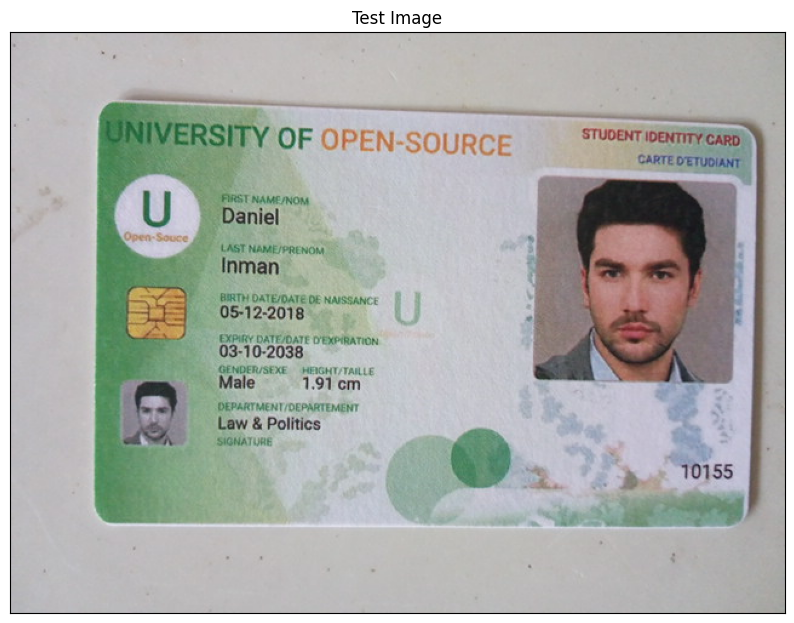

In [20]:
# pick one image from the test set
id = 7
image = Image.open(detection_test_set.image_urls[id])
image = Image.open('images/student-ids/10155.jpg')
image_tensor = imgToTensor(image)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
ax.set_title('Test Image')
plt.imshow(image)

# put the model in evaluation mode
detection_model.eval()
with torch.no_grad():
    pass
    # forward pass the test image to get detection predictions
    detection_predictions = detection_model(image_tensor.unsqueeze(0).to(device))

Secondly, let's take a look at the raw outputs predicted by our detection model for the image above.

In [21]:
print(detection_predictions[0]['labels'].size()[0], 'objects detected !')
detection_predictions[0]

1 objects detected !


{'boxes': tensor([[ 67.1795,  61.6876, 619.1157, 417.1081]], device='cuda:0'),
 'labels': tensor([1], device='cuda:0'),
 'scores': tensor([1.0000], device='cuda:0'),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')}

Lastly, let's convert the raw predicted outputs into human a understandable form for proper visualisation.

Text(0.5, 1.0, 'Segentation Mask')

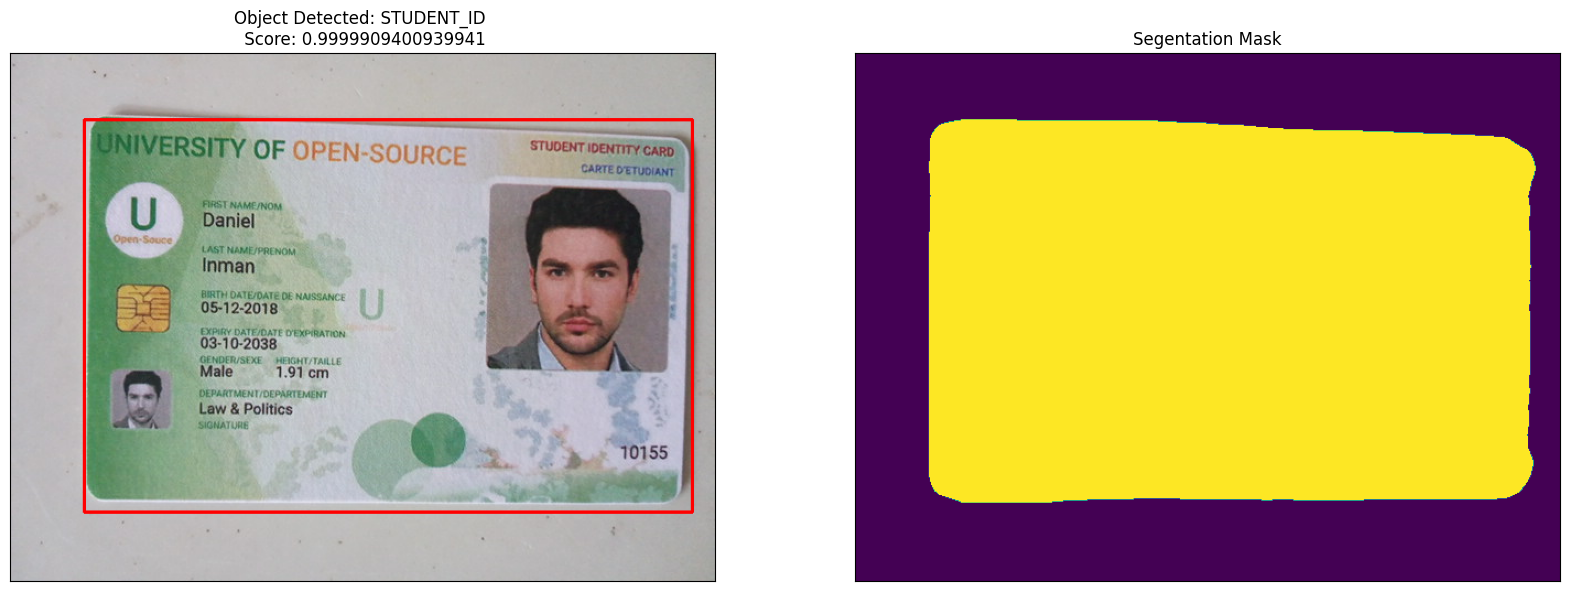

In [22]:
# Select an index for a detected/predicted object
idx = 0

image_array = np.array(image)
# Retrieve predicted bounding box for detected object
box_tensor = detection_predictions[0]['boxes'][idx]
box = [int(cord) for cord in box_tensor.cpu().numpy()]
# draw predicted bounding box on image
cv2.rectangle(image_array, (box[0],box[1]), (box[2],box[3]), (255,0,0), 2)

# Retrieve predicted mask for detected object
mask_tensor = detection_predictions[0]['masks'][idx]
# Threshold mask tensor
mask_tensor = mask_tensor > 0.5
mask_tensor = mask_tensor.float()

mask = tensorToPIL(mask_tensor)

# Retrieve predictied label for detected object
label_idx = detection_predictions[0]['labels'][idx].item()
label = detection_classes[label_idx]

# Retrieve predictied score for detected object
score = detection_predictions[0]['scores'][idx].item()

fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plt.imshow(image_array)
ax.set_title('Object Detected: {} \n Score: {}'.format(label, score))
ax1 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plt.imshow(mask)
ax1.set_title('Segentation Mask')

## 1.4. Student ID Alignment
At the begining of this tutorial, we've mentioned that the goal of the detection module was to predict the position of documents of interest (which are student-ids in our case) with-in an image, but it does more than that. The segmentation mask computed for a student-id is used to perform image alignment on that student-id. The resulting aligned image is then fed as input to the orientation module.

In [23]:
def align_student_id(image, mask) :
    # Extract quadreploid of segmented image
    X = np.nonzero(mask)[1]
    Y = np.nonzero(mask)[0]
    points = np.vstack((X, Y)).T
    rect = utils.order_points(points)

    # align detected student id
    image_array = np.array(segmented_image)
    aligned_image_array = utils.warp_perspective_image(image_array, rect)
    aligned_image_array = cv2.cvtColor(aligned_image_array, cv2.COLOR_BGR2RGB)

    return Image.fromarray(aligned_image_array)

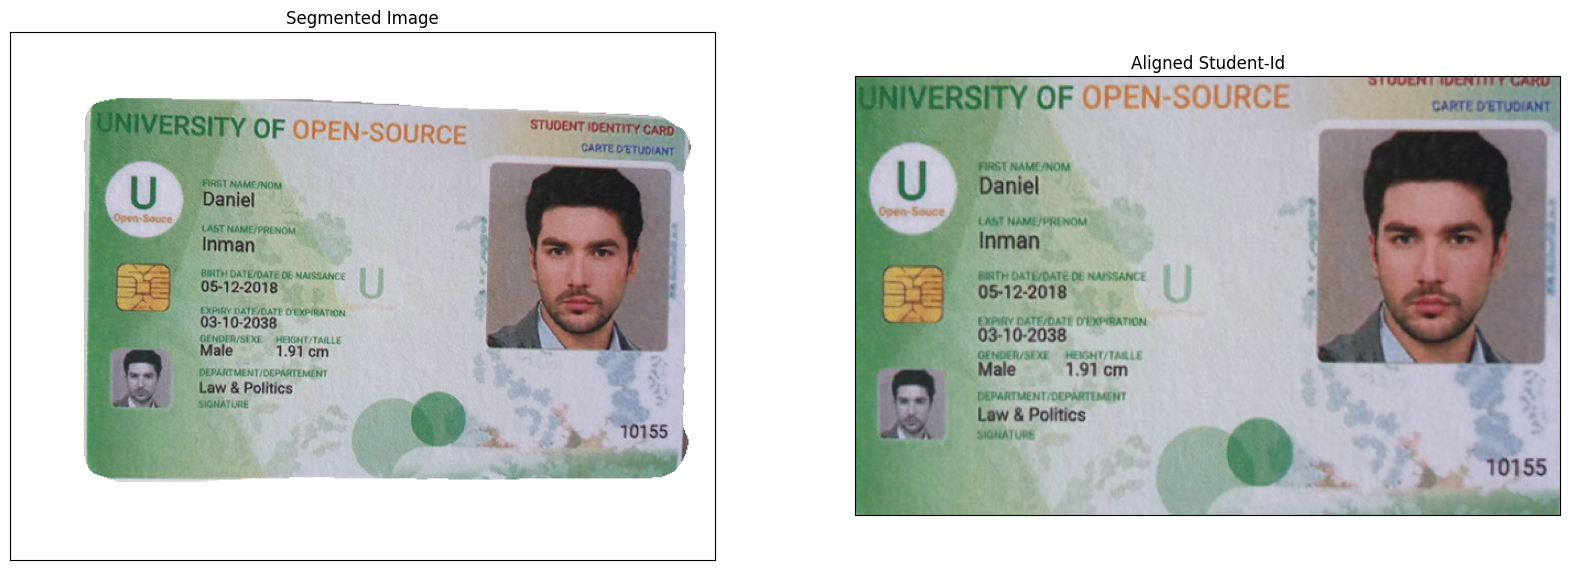

In [24]:
segmented_image = utils.segment_image(image, mask)
aligned_student_id = align_student_id(image, mask)

fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Segmented Image')
plt.imshow(segmented_image)

ax1 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax1.set_title('Aligned Student-Id',)
plt.imshow(aligned_student_id)

In [25]:
aligned_student_id.save('images/aligned_image.jpg')

In [26]:
plt.rcParams['axes.titlesize'] = 15

# **2. Orientation Module**
In order to predict the orientation of an aligned student-id image inputed from the detection module, we shall quickly develop an image classification model and train it on our orientation dataset. We expect the trained orientation model to predict the confidence scores of orientation angles (90, 180, 270, and 360) for an input image

In [5]:
# resolve imports for orientation module
import os
import cv2
import time
import torch
import torchvision

import numpy as np

import utils

from PIL import Image, ImageDraw
#%matplotlib inline
from matplotlib import pyplot as plt

# define transforms to convert PIL image to torch.Tensor
imgToTensor = torchvision.transforms.ToTensor()
# define transforms to convert torch.Tensor to PIL image
tensorToPIL = torchvision.transforms.ToPILImage()


## 2.1. Orientation Dataset
The orientation dataset consist of a folder containing four subfolders, where by, each subfolder is named according to one of the four orientation classes i.e. **'090'**, **'180'**, **'270'**, and **'360'**. Each subfolder contains images rotated according to their folder's name.

Pytorch provide utilities for loading datasets with such format without requiring us to hardcode a custom dataset class for the data like we did for the detection dataset.

### 2.1.1. Define transforms for orientation datasets
Before initializing our various orientation datasets, we have to define the various transforms which shall be used to initialze them.

In [6]:
import torchvision.transforms as transforms

# transforms for training set
orientation_transform_train = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(1.0, 1.1), shear=5),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)], p=0.5),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# transforms for testing set
orientation_transform_test = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# transforms for validation set
orientation_transform_valid = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


### 2.1.2.  Initialize orientation datasets
We shall leverage Pytorch in built torchvision.datasets.ImageFolder class to effortessly initialize our orientation training, validation and testing datasets.

In [7]:
from torchvision import datasets

# define urls of our datasets folders
orientation_data_path = os.path.join('datasets', 'orientation')
orientation_train_images_path = os.path.join(orientation_data_path, 'train')
orientation_valid_images_path = os.path.join(orientation_data_path, 'valid')
orientation_test_images_path = os.path.join(orientation_data_path, 'test')

# initialize training dataset for orientation module
orientation_train_set = datasets.ImageFolder(orientation_train_images_path, orientation_transform_train)
# initialize validation dataset for orientation module
orientation_valid_set = datasets.ImageFolder(orientation_valid_images_path, orientation_transform_valid)
# initialize testing dataset for orientation module
orientation_test_set = datasets.ImageFolder(orientation_test_images_path, orientation_transform_test)
# retrieve orientation classes
orientation_classes = orientation_train_set.classes
num_orientation_classes = len(orientation_classes)


Let's print the our datasets classes to make sure things are **OK** !

In [8]:
print('Number of classes: {}\nClasses: {}'.format(num_orientation_classes, orientation_classes))


Number of classes: 4
Classes: ['090', '180', '270', '360']


### 2.1.3. Visualize orientation dataset

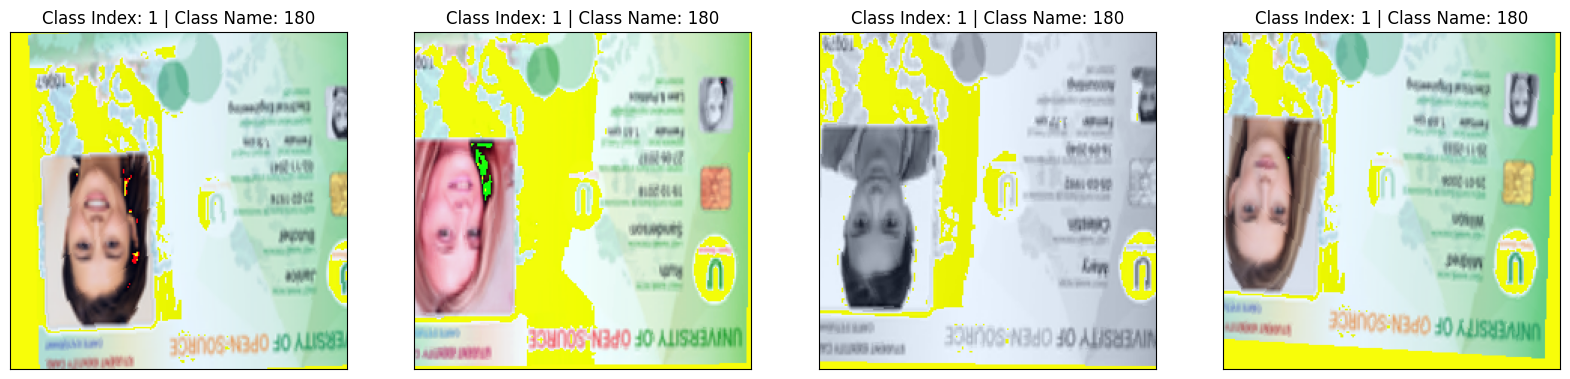

In [9]:
import random

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 40))
# visualize transformed data
for counter in range(4):
  image_tensor, label_tensor = orientation_train_set[random.choice(range(0, len(orientation_train_set)))]
  image_tensor = image_tensor * 0.226 + 0.445  # denormalize tensor
  ax = fig.add_subplot(1, 4, counter+1, xticks=[], yticks=[])
  plt.imshow(tensorToPIL(image_tensor))
  ax.set_title('Class Index: {} | Class Name: {}'.format(label_tensor, orientation_classes[label_tensor]))


## 2.2. Orientation Model

### 2.2.1. Define Orientation Model
Let's define an architechture for our orientation model from scratch.
\
**Note** that the model architechture defined below expects input image tensors of shape  **(3 x 224 x 224)** similar to the shape specified by the transforms of the orientation datasets.

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class OrientationModel(torch.nn.Module):
    def __init__(self, num_classes):
        super(OrientationModel, self).__init__()
        # Define convolutional layers
        self.layer_1_conv = nn.Conv2d(3, 32, (3, 3), stride=1, padding=1)  # W = 112
        self.layer_2_conv = nn.Conv2d(32, 64, (3, 3), stride=1, padding=1)  # W = 56
        self.layer_3_conv = nn.Conv2d(64, 128, (3, 3), stride=1, padding=1)  # W = 28

        # Define maxpool and dropout layers
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.2)

        # Define the fully-connected or linear layers
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 512)
        # The outputs of the last linear equals the number of orientation classes
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.layer_1_conv(x)))
        x = self.pool(F.relu(self.layer_2_conv(x)))
        x = self.pool(F.relu(self.layer_3_conv(x)))

        x = x.view(-1, 128 * 28 * 28)
        # Insert an activation layer after every linear layer
        x = F.relu(self.fc1(self.dropout(x)))
        x = F.relu(self.fc2(self.dropout(x)))
        x = F.relu(self.fc3(self.dropout(x)))

        return x # return orientation prediction


Now that we have defined the architechture of our orientation model, let's define the helper function to instantiate it !

In [11]:
def get_orientation_model(num_classes, model_state_dict=None):
    orientation_model = OrientationModel(num_classes)
    # initialize model state dictionary if specified
    if not model_state_dict == None: orientation_model.load_state_dict(model_state_dict)

    return orientation_model


### 2.2.2. Specify checkpoint and initialize model
Looking forward to **resumable** training and saving of our orientation model, we shall now specify the checkpoints for the **state dictionaries** of the model and its training optimizer.

In [12]:
# select hardware type use for computations
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

load_orientation_checkpoint = True
save_orientation_checkpoint = True

orientation_checkpoint_path = os.path.join('checkpoints', 'orientation_model_scratch.pth.tar')

'''
Do not edit the lines below
'''

if load_orientation_checkpoint:
  orientation_checkpoint = torch.load(orientation_checkpoint_path, map_location=device) if os.path.exists(orientation_checkpoint_path) else None
  orientation_model_state_dict = orientation_checkpoint['model_state_dict'] if not orientation_checkpoint == None else None
  orientation_optimizer_state_dict = orientation_checkpoint['optimizer_state_dict'] if not orientation_checkpoint == None else None
else:
  orientation_checkpoint, orientation_model_state_dict, orientation_optimizer_state_dict = None, None, None

if not save_orientation_checkpoint : orientation_checkpoint_path = None
# initialize orientation model using the state dictionary from checkpoint
orientation_model = get_orientation_model(num_orientation_classes, model_state_dict = orientation_model_state_dict).to(device)

if orientation_checkpoint is None : print('No checkpoint loaded ! Initialized model from scratch instead...')
else :
  print('Loaded model from checkpoint...')
  utils.checkpoint_summary(orientation_checkpoint)


No checkpoint loaded ! Initialized model from scratch instead...


Let's print our orientation to see if it has been initialized as we expect.

In [13]:
orientation_model


OrientationModel(
  (layer_1_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_2_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_3_conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=4, bias=True)
)

## 2.3. Training and Evaluation

### 2.3.1. Specify data loaders
After initialising the various orientation datasets, let us use them to specify data loaders which shall be used for training, validation and testing.

In [14]:
num_workers = 0

# data loader for training
orientation_train_loader = torch.utils.data.DataLoader(
    orientation_train_set, batch_size=4, shuffle=True, num_workers=num_workers
)
# data loader for validation
orientation_valid_loader = torch.utils.data.DataLoader(
    orientation_valid_set, batch_size=4, shuffle=True, num_workers=num_workers
)
# data loader for testing
orientation_test_loader = torch.utils.data.DataLoader(
    orientation_test_set, batch_size=2, shuffle=False, num_workers=num_workers
)

# defining orientation data loaders dictionary
orientation_loaders = {
    'train' : orientation_train_loader,
    'valid' : orientation_valid_loader,
    'test' : orientation_test_loader,
}


### 2.3.2. Define loss function and optimizer
Lets initialize optimizer for training the orientation model, and get ready for training !

In [15]:
# Select loss criterion
orientation_criterion = torch.nn.CrossEntropyLoss()
# Select optimizer
orientation_optimizer = torch.optim.SGD(orientation_model.parameters(), lr=0.001)
# Regularization. Decay LR by a factor of 0.9 every 15 epochs
orientation_lr_scheduler = torch.optim.lr_scheduler.StepLR(orientation_optimizer, step_size=15, gamma=0.9)

# load optimizer state dictionary from checkpoint if available
if orientation_optimizer_state_dict is None:  print('No checkpoint loaded ! Optimizer not loaded from checkpoint...')
else:
    orientation_optimizer.load_state_dict(orientation_optimizer_state_dict)
    print('Loaded optimizer from checkpoint...')


No checkpoint loaded ! Optimizer not loaded from checkpoint...


### 2.3.3. Define training function

In [16]:
def train_orientation_model(model, checkpoint, num_epochs, optimizer, criterion,
            use_cuda=True, checkpoint_path=None, loaders=None, scheduler=None):
    # Specify hardware type for training
    device = torch.device('cuda') if use_cuda else torch.device('cpu')

    best_model_state_dict = None
    best_optimizer_state_dict = None
    import os

    checkpoint_path = "content/checkpoints/orientation"
    if not os.path.isdir(os.path.dirname(checkpoint_path)):
        os.makedirs(os.path.dirname(checkpoint_path))
    if checkpoint == None:
        start_epoch = 1
        best_loss = np.inf
    else:
        print('Resuming training from checkpoint...')
        best_loss = checkpoint['best_loss']
        model_state_dict = checkpoint['model_state_dict']
        optimizer_state_dict = checkpoint['optimizer_state_dict']
        best_model_state_dict = model_state_dict
        best_optimizer_state_dict = optimizer_state_dict
        start_epoch = checkpoint['epoch'] + 1
    # move model to hardware
    model.to(device)

    # initialize tracker for minimum validation loss
    valid_loss_min = best_loss

    time_train = time.time()
    for epoch in range(start_epoch, num_epochs + 1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        time_epoch = time.time()

        ### Defining training block
        # set model to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move data to hardware
            data, target = data.to(device), target.to(device)
            ## find the training loss and update the model parameters accordingly
            # reset gradients
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            # record the average training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

        if scheduler is not None: scheduler.step()

        ### Defining validation block
        # set model for evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move data to hardware
            data, target = data.to(device), target.to(device)
            ## find the validation
            output = model(data)
            loss = criterion(output, target)
            # update the average validation loss
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

        # print training and validation statistics
        time_epoch_elapsed = time.time() - time_epoch
        time_train_elapsed = time.time() - time_train
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tEpoch Time: {:.0f}m {:.0f}s \tElapsed Time: {:.0f}m {:.0f}s'
                .format(epoch, train_loss, valid_loss, time_epoch_elapsed // 60, time_epoch_elapsed % 60,
                time_train_elapsed // 60, time_train_elapsed % 60))

        ## update checkpoint if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving best checkpoint ...'
                    .format(valid_loss_min, valid_loss))
            ## update checkpoint if checkpoint path is given
            if checkpoint_path is not None:
                best_training_epoch = epoch
                best_model_state_dict = model.state_dict()
                best_optimizer_state_dict = optimizer.state_dict()
                utils.save_checkpoint(best_model_state_dict, best_optimizer_state_dict,
                                      best_training_epoch, checkpoint_path, loss= valid_loss)
            valid_loss_min = valid_loss

    ## update checkpoint if checkpoint path is given
    if checkpoint_path is not None:
        if best_model_state_dict == None and best_optimizer_state_dict:
            print('No validation loss decrease ! Saving checkpoint ...')
            utils.save_checkpoint(model.state_dict(), optimizer.state_dict(), num_epochs,
                                  checkpoint_path, loss= valid_loss_min)
        else:
            print('Saving checkpoint ...')
            utils.save_checkpoint(best_model_state_dict, optimizer.state_dict(), num_epochs,
                                  checkpoint_path, loss= valid_loss_min)
    # return trained model
    print('Training Complete ...')
    return model


### 2.3.4. Train orientation model
Now let's train our orientation model for 30 epochs.

In [17]:
# start training the orientation model for 20 epochs
orientation_model = train_orientation_model(orientation_model, orientation_checkpoint, 20,
                        orientation_optimizer, orientation_criterion, use_cuda = torch.cuda.is_available(),
                        checkpoint_path = orientation_checkpoint_path, loaders = orientation_loaders)

Epoch: 1 	Training Loss: 1.386117 	Validation Loss: 1.379943 	Epoch Time: 0m 9s 	Elapsed Time: 0m 9s
Validation loss decreased (inf --> 1.379943).  Saving best checkpoint ...
Epoch: 2 	Training Loss: 1.383185 	Validation Loss: 1.374093 	Epoch Time: 0m 1s 	Elapsed Time: 0m 10s
Validation loss decreased (1.379943 --> 1.374093).  Saving best checkpoint ...
Epoch: 3 	Training Loss: 1.377656 	Validation Loss: 1.366203 	Epoch Time: 0m 1s 	Elapsed Time: 0m 12s
Validation loss decreased (1.374093 --> 1.366203).  Saving best checkpoint ...
Epoch: 4 	Training Loss: 1.368185 	Validation Loss: 1.355467 	Epoch Time: 0m 2s 	Elapsed Time: 0m 14s
Validation loss decreased (1.366203 --> 1.355467).  Saving best checkpoint ...
Epoch: 5 	Training Loss: 1.363138 	Validation Loss: 1.339027 	Epoch Time: 0m 1s 	Elapsed Time: 0m 15s
Validation loss decreased (1.355467 --> 1.339027).  Saving best checkpoint ...
Epoch: 6 	Training Loss: 1.352396 	Validation Loss: 1.317396 	Epoch Time: 0m 2s 	Elapsed Time: 0m 18s

### 2.3.5. Resume training orientation model
At the end of every epoch, we had the checkpoints of the orientation module updated. Now let's use these updated checkpoints to reload the orientation model with orientation optimizer and resume the training up to **'30'** epochs.\
**[IMPORTANT !!!]** To reload the orientation model and the orientation optimizer from checkpoint, simply re-run the code cell at Section 2.2.2. and Section 2.3.2 respectively.\
Just make sure ``load_orientation_checkpoint`` is set to ``True``. The resulting output shall be identical to the one below.

Reloading orientation model from checkpoint. (Section 2.2.2)

In [18]:
# select hardware type use for computations
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

load_orientation_checkpoint = True
save_orientation_checkpoint = True

orientation_checkpoint_path = os.path.join('checkpoints', 'orientation_model_scratch.pth.tar')

'''
Do not edit the lines below
'''

if load_orientation_checkpoint:
  orientation_checkpoint = torch.load(orientation_checkpoint_path, map_location=device) if os.path.exists(orientation_checkpoint_path) else None
  orientation_model_state_dict = orientation_checkpoint['model_state_dict'] if not orientation_checkpoint == None else None
  orientation_optimizer_state_dict = orientation_checkpoint['optimizer_state_dict'] if not orientation_checkpoint == None else None
else:
  orientation_checkpoint, orientation_model_state_dict, orientation_optimizer_state_dict = None, None, None

if not save_orientation_checkpoint : orientation_checkpoint_path = None
# initialize orientation model using the state dictionary from checkpoint
orientation_model = get_orientation_model(num_orientation_classes, model_state_dict = orientation_model_state_dict).to(device)

if orientation_checkpoint is None : print('No checkpoint loaded ! Initialized model from scratch instead...')
else :
  print('Loaded model from checkpoint...')
  utils.checkpoint_summary(orientation_checkpoint)

No checkpoint loaded ! Initialized model from scratch instead...


Reloading orientation optimizer from checkpoint (Section 2.3.2)

In [19]:
# Select loss criterion
orientation_criterion = torch.nn.CrossEntropyLoss()
# Select optimizer
orientation_optimizer = torch.optim.SGD(orientation_model.parameters(), lr=0.001)
# Regularization. Decay LR by a factor of 0.9 every 15 epochs
orientation_lr_scheduler = torch.optim.lr_scheduler.StepLR(orientation_optimizer, step_size=15, gamma=0.9)
# load optimizer state dictionary from checkpoint if available

if orientation_optimizer_state_dict is not None:
    orientation_optimizer.load_state_dict(orientation_optimizer_state_dict)
    print('Loaded optimizer from checkpoint...')

Now let's resume training of our orientation model.

In [20]:
# resume training of orientation model up to 30 epochs
orientation_model = train_orientation_model(orientation_model, orientation_checkpoint, 30,
                        orientation_optimizer, orientation_criterion, use_cuda = torch.cuda.is_available(),
                        checkpoint_path = orientation_checkpoint_path, loaders = orientation_loaders)

Epoch: 1 	Training Loss: 1.386136 	Validation Loss: 1.379268 	Epoch Time: 0m 1s 	Elapsed Time: 0m 1s
Validation loss decreased (inf --> 1.379268).  Saving best checkpoint ...
Epoch: 2 	Training Loss: 1.381078 	Validation Loss: 1.372794 	Epoch Time: 0m 1s 	Elapsed Time: 0m 2s
Validation loss decreased (1.379268 --> 1.372794).  Saving best checkpoint ...
Epoch: 3 	Training Loss: 1.376029 	Validation Loss: 1.366034 	Epoch Time: 0m 1s 	Elapsed Time: 0m 4s
Validation loss decreased (1.372794 --> 1.366034).  Saving best checkpoint ...
Epoch: 4 	Training Loss: 1.373348 	Validation Loss: 1.358822 	Epoch Time: 0m 1s 	Elapsed Time: 0m 5s
Validation loss decreased (1.366034 --> 1.358822).  Saving best checkpoint ...
Epoch: 5 	Training Loss: 1.369004 	Validation Loss: 1.350104 	Epoch Time: 0m 1s 	Elapsed Time: 0m 7s
Validation loss decreased (1.358822 --> 1.350104).  Saving best checkpoint ...
Epoch: 6 	Training Loss: 1.363527 	Validation Loss: 1.340670 	Epoch Time: 0m 1s 	Elapsed Time: 0m 8s
Vali

You notice that the training start from epoch 21 since the orientation model has already been trained for 20 epochs.

### 2.3.6. Evaluate orientation model
To conclude on the performance of yours models, it is always of good practice to evaluate it on sample data.
We shall evaluate the performance of the orientation model on sample images from the testing dataset.

Firstly, let's use our orientation model to predict orientation of an input image from the test orientation dataset.

However, before that let's define test function.

In [21]:
def test_orientation_model(model, criterion, loaders=None, use_cuda= False):
    # Specify hardware for testing
    device = torch.device('cuda') if use_cuda else torch.device('cpu')
    # move model to selected hardware
    model = model.to(device)

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loaders['test']):
            # move data and labels to selected hardware
            data, target = data.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # update average test loss
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
            # convert output scores to predicted class
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

With our test function defined, we shall use it to evaluate the performance of the orientation model on the orientation test dataset.

In [22]:
# call test function
test_orientation_model(orientation_model, orientation_criterion, orientation_loaders, use_cuda= False)

Test Loss: 0.003611


Test Accuracy: 100% (28/28)


## 2.4 Orientation Correction

Let's inference our trained orientation model with sample images from test dataset one at the time to properly visualize its performance. Keep in mind that the objective behind an orientation module is to detect the orientation of an aligned document image, and to rectify it where necessary. Therefore, after inferencing every single image, we have shall apply the proper transformation to the image in order to rectify it's orientation if necessary.

In [23]:
image_url, _ = orientation_test_set.imgs[0]

In [24]:
plt.rcParams['axes.titlesize'] = 20

Raw predictions:  tensor([0.0000, 2.1819, 0.0000, 6.4940], grad_fn=<SelectBackward0>)


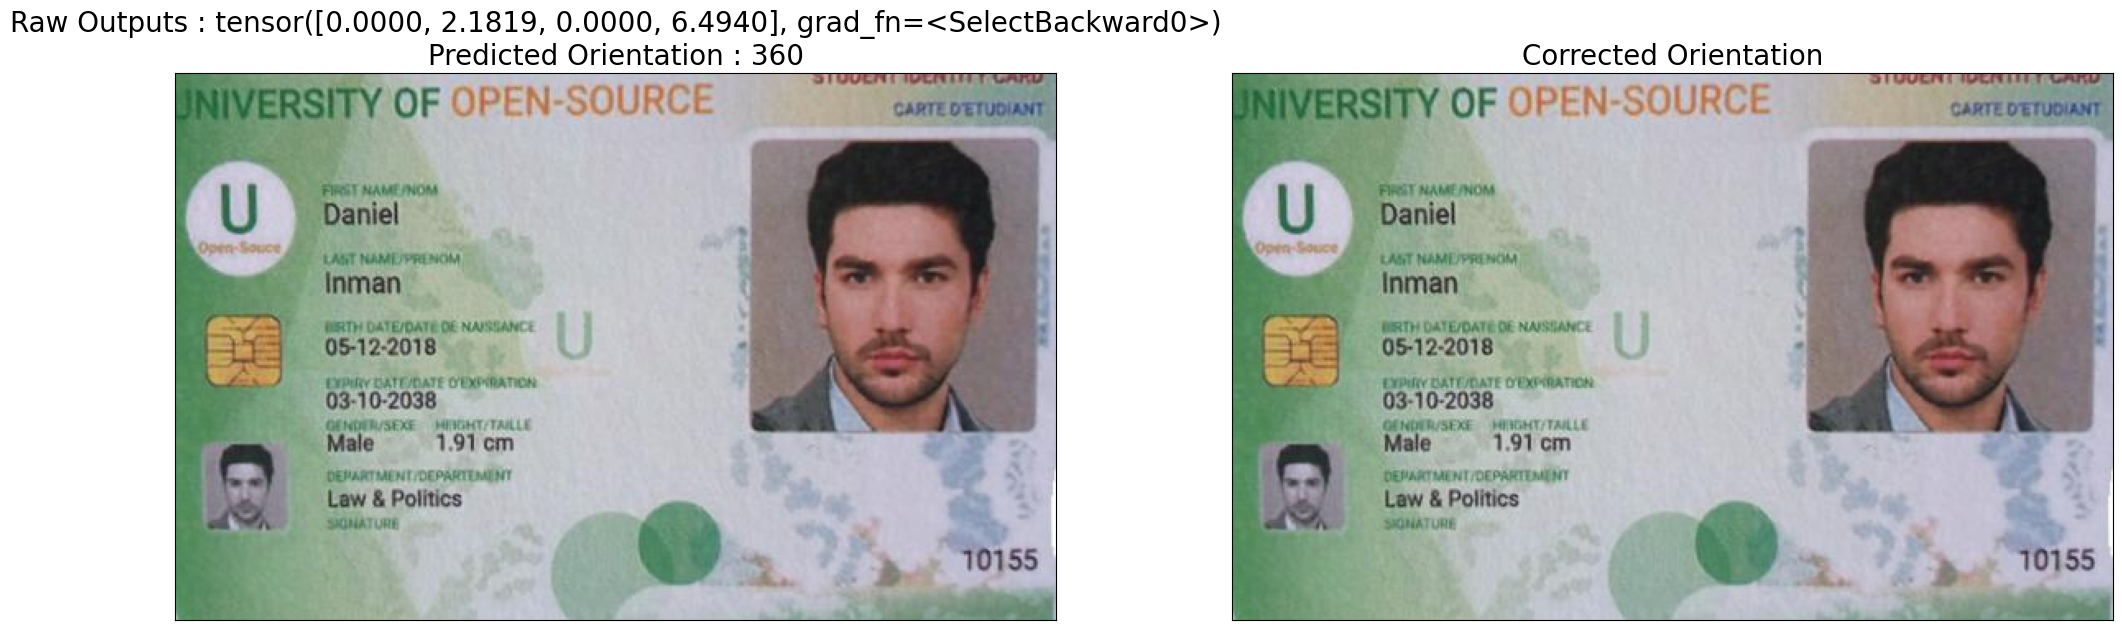

In [25]:
# define function to correct orientation
def rectify_orientation(image, rotation_angle):
    if rotation_angle == '090': return image.transpose(Image.ROTATE_270)
    elif rotation_angle == '180': return image.transpose(Image.ROTATE_180)
    elif rotation_angle == '270': return image.transpose(Image.ROTATE_90)
    else: return image

image = Image.open('images/aligned_image.jpg')
image_tensor =  orientation_transform_test(image)
orientation_prediction = orientation_model(image_tensor.unsqueeze(0))[0]
print('Raw predictions: ', orientation_prediction)

# retrieve index for maximum score
orientation_index = torch.argmax(orientation_prediction)
# retrieve class of maximun score
orientation_class = orientation_classes[orientation_index]

fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Raw Outputs : {}\nPredicted Orientation : {}'.format(orientation_prediction, orientation_class))
plt.imshow(image)
ax1 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax1.set_title('Corrected Orientation')
plt.imshow(rectify_orientation(image, orientation_class))
None

In [26]:
! zip -r checkpoints.zip checkpoints

	zip warning: name not matched: checkpoints

zip error: Nothing to do! (try: zip -r checkpoints.zip . -i checkpoints)


# **2. Extraction Module**

Select an image for inference

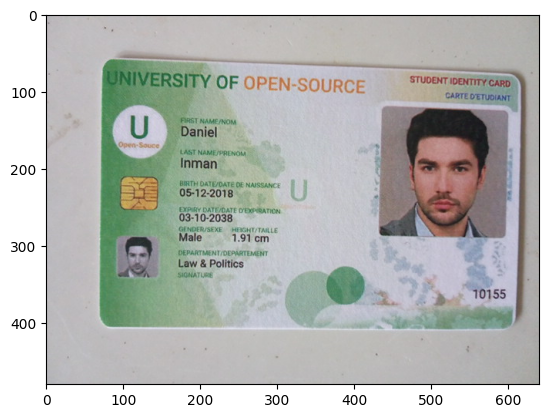

In [27]:
image = Image.open('images/student-ids/10157.jpg')
plt.imshow(image)
# convert image to a tensor
image_tensor = torchvision.transforms.ToTensor()(image)

Predict student-id(s) using the detection model

In [28]:
# put the detection model in evaluation mode
detection_model.eval()
with torch.no_grad():
    # forward pass the test image to get detection predictions
    detection_predictions = detection_model(image_tensor.unsqueeze(0).to(device))

NameError: ignored

Visualize the raw predictions

In [ ]:
print(detection_predictions[0]['labels'].size()[0], 'objects detected !')
detection_predictions[0]

1 objects detected !


{'boxes': tensor([[ 57.7098,  58.0544, 618.8468, 417.4893]]),
 'labels': tensor([1]),
 'scores': tensor([0.9999]),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]])}

Extract segmentation mask

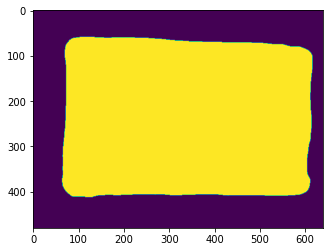

In [ ]:
mask_tensor = detection_predictions[0]['masks'][idx]
mask_tensor = utils.denoise_mask_tensor(mask_tensor.cpu())
mask = torchvision.transforms.ToPILImage()(mask_tensor)
plt.imshow(mask)

Align image using segmentation mask

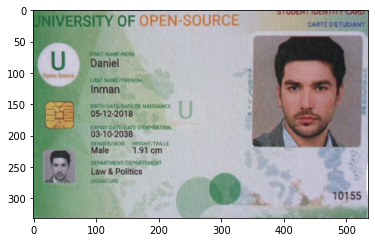

In [ ]:
#segment image using segmentationmask
segmented_image = utils.segment_image(image, mask)

# Extract quadreploid of segmented image
X = np.nonzero(mask)[1]
Y = np.nonzero(mask)[0]
points = np.vstack((X, Y)).T
rect = utils.order_points(points)

# align detected student id
segmented_mage_array = np.array(segmented_image)
aligned_image_array = utils.warp_perspective_image(segmented_mage_array, rect)
aligned_image_array = cv2.cvtColor(aligned_image_array, cv2.COLOR_BGR2RGB)
aligned_image = Image.fromarray(aligned_image_array)
plt.imshow(aligned_image)

Predict and correct orientation.

Raw predictions:  tensor([0.0000, 2.8216, 0.0000, 8.2350], grad_fn=<SelectBackward>)


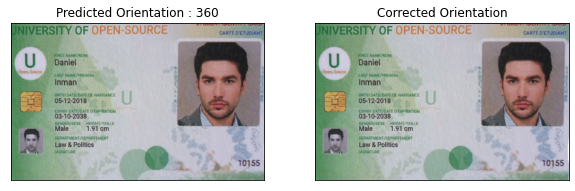

In [ ]:
image_tensor = orientation_transform_test(aligned_image)
orientation_prediction = orientation_model(image_tensor.unsqueeze(0))[0]
print('Raw predictions: ', orientation_prediction)

# retrieve index for maximum score
orientation_index = torch.argmax(orientation_prediction)
# retrieve class of maximun score
orientation_class = orientation_classes[orientation_index]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Predicted Orientation : {}'.format(orientation_class))
plt.imshow(aligned_image)
ax1 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax1.set_title('Corrected Orientation')
aligned_image = rectify_orientation(aligned_image, orientation_class)
plt.imshow(aligned_image)
None

## Extract fields using relative coordinates from ``field_coordinates.yaml``

In [ ]:
import yaml

field_coordinates_file = './field_coordinates.yaml'
with open(field_coordinates_file) as f:
    field_coordinates = yaml.load(f, Loader=yaml.FullLoader)

# print field coordinates
field_coordinates

{'image_width': 324,
 'image_height': 204,
 'firstname': {'width': 125, 'height': 25, 'left': 55, 'top': 40},
 'lastname': {'width': 125, 'height': 25, 'left': 55, 'top': 65},
 'gender': {'width': 45, 'height': 20, 'left': 55, 'top': 123},
 'height': {'width': 45, 'height': 20, 'left': 100, 'top': 123},
 'birth_date': {'width': 125, 'height': 20, 'left': 55, 'top': 90},
 'department': {'width': 125, 'height': 20, 'left': 55, 'top': 140},
 'expiry_date': {'width': 125, 'height': 20, 'left': 55, 'top': 105},
 'photo': {'width': 110, 'height': 110, 'left': 210, 'top': 25},
 'mini_photo': {'width': 35, 'height': 35, 'left': 12, 'top': 132},
 'signature': {'width': 125, 'height': 44, 'left': 55, 'top': 160},
 'id': {'width': 45, 'height': 20, 'left': 279, 'top': 170}}

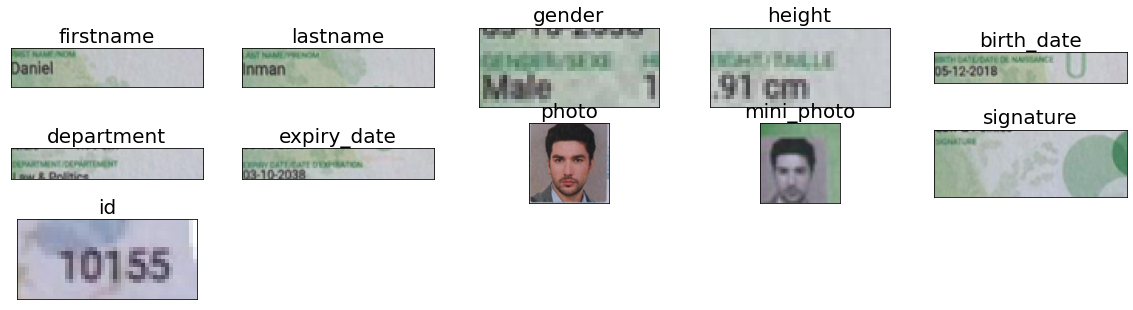

In [ ]:
import math

aligned_image = Image.open('images/aligned_image.jpg')
# get size of aligned image
image_width = aligned_image.width
image_height = aligned_image.height

im_width = field_coordinates['image_width']
im_height = field_coordinates['image_height']

image_array = np.array(aligned_image.resize((im_width, im_height)))

num_col = 5
fig = plt.figure(figsize=(20, 5))
for counter, field_id in enumerate(field_coordinates):
    if field_id in ['image_width', 'image_height'] : continue
    cords = field_coordinates[field_id]
    x1, y1, x2, y2 = cords['left'], cords['top'], cords['width']+cords['left'], \
                        cords['height']+cords['top']
    crop_cords = x1, y1, x2, y2
    cropped_image = utils.crop_image(image_array, crop_cords)
    ax = fig.add_subplot(math.ceil(len(field_coordinates)/num_col), num_col, counter-1, xticks=[], yticks=[])
    plt.imshow(cropped_image)
    ax.set_title('{}'.format(field_id))